In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator
import control

### Large Signal

In [2]:
Vg = 24
RL = 60e-3
R = 100
Dp = 0.4988
# V
(Vg/Dp)*1/(1+(RL/(R*Dp**2)))

47.999722856451825

In [3]:
# I
(Vg/(R*Dp**2))*1/(1+(RL/(R*Dp**2)))

0.9623039866971096

In [4]:
fclk = 100e6 # 100 MHz clk
fsw = 10e3 # 10 kHz switching
Nr = fclk/(2*fsw)

Dp = 0.5
f0 = (Vg/Dp)*1/(1+(RL/(R*Dp**2)))

q = 1/Nr
Dp = 0.5-q
f1 = (Vg/Dp)*1/(1+(RL/(R*Dp**2)))

print(f'Output Voltage Resolution: {round(abs(f0-f1),4)} V')
print(f'Smallest Duty Cycle: {q} = {q*100}%')
print(f'Sensing Voltage Resolution: {round(f1/2**12,4)}V')

Output Voltage Resolution: 0.0191 V
Smallest Duty Cycle: 0.0002 = 0.02%
Sensing Voltage Resolution: 0.0117V


### Small Signal

In [5]:
s,n,R_L,R,L,C,D,Dp,V_g = sp.symbols("s,n,R_L,R,L,C,D,D',V_g")

In [6]:
A = sp.Matrix([
    [-R_L/L, -Dp/L],
    [Dp/C, -1/(R*C)]
])

In [7]:
B = sp.Matrix([
    [(V_g/(Dp*L))*(1/(1+(R_L/(Dp**2*R)))), 1/L],
    [(-V_g/(Dp**2*R*C))*(1/(1+(R_L/(Dp**2*R)))), 0]
])

In [8]:
C = sp.eye(2)
E = sp.Matrix([[0, 0],[0, 0]])
I = sp.eye(2)

In [9]:
tf = C*(s*I-A).inv()*B+E

In [10]:
H = sp.Matrix(tf)

In [11]:
sp.simplify(H)

Matrix([
[       D'*R*V_g*(C*R*s + 2)/((D'**2*R + R_L)*(C*L*R*s**2 + C*R*R_L*s + D'**2*R + L*s + R_L)), (C*R*s + 1)/(C*L*R*s**2 + C*R*R_L*s + D'**2*R + L*s + R_L)],
[R*V_g*(D'**2*R - L*s - R_L)/((D'**2*R + R_L)*(C*L*R*s**2 + C*R*R_L*s + D'**2*R + L*s + R_L)),        D'*R/(C*L*R*s**2 + C*R*R_L*s + D'**2*R + L*s + R_L)]])

In [12]:
sp.simplify(H[2]/H[0]) 

(D'**2*R - L*s - R_L)/(D'*(C*R*s + 2))

In [13]:
system = {
    'R_L':60e-3,
    'R'  :100,
    'L'  :0.2e-3,
    'C'  :2200e-6,
    "D'"  :0.4988,
    'V_g' :24
}
H0 = H[0].subs(system)
H1 = H[1].subs(system)
H2 = H[2].subs(system)
H3 = H[3].subs(system)

In [14]:
sp.simplify(H0)
sp.simplify(H1)
sp.simplify(H2)
sp.simplify(H3)

(10.5599390284194*s + 95.9994457129037)/(4.4e-5*s**2 + 0.0134*s + 24.940144)

(0.22*s + 1.0)/(4.4e-5*s**2 + 0.0134*s + 24.940144)

(2388.45235215963 - 0.0192460797339422*s)/(4.4e-5*s**2 + 0.0134*s + 24.940144)

49.88/(4.4e-5*s**2 + 0.0134*s + 24.940144)

In [15]:
sp.simplify((H[2]/H[0]).subs(system))

(2388.45235215963 - 0.0192460797339422*s)/(10.5599390284194*s + 95.9994457129037)

### gain, zero, pole

In [16]:
s  = control.TransferFunction.s

In [17]:
Gid =  (10.559939*s+95.999446)/(4.4e-5*s**2+0.0134*s+24.940144)
Gid.dcgain()
Gid.zero()
Gid.pole()

array(3.84919373)

array([-9.09090914])

array([-152.27272727+737.31572008j, -152.27272727-737.31572008j])

In [18]:
Gvd = (2388.452352-0.019246*s)/(4.4e-5*s**2+0.0134*s+24.940144)
Gvd.dcgain()
Gvd.zero()
Gvd.pole()

array(95.76738418)

array([124101.23412657])

array([-152.27272727+737.31572008j, -152.27272727-737.31572008j])

In [19]:
Gvi = (2388.452352-0.019246*s)/(10.559939*s+95.999446)
Gvi.dcgain()
Gvi.zero()
Gvi.pole()

array(24.87985558)

array([124101.23412657])

array([-9.09090914])

### gm, pm, wg, wp

In [20]:
gm, pm, wg, wp = control.margin(Gvi)
gm, round(pm,4), wg, round(wp,4)

(inf, 92.1992, nan, 225.9981)

### Design

In [21]:
# fci < (fsw/10 = 10kHz/10 = 1kHz)
# PI Controller: kp + ki/s = (kp*s+ki)/s = (s/a + ki)/s
# Kp = 1/a



In [22]:
s,n,R_L,R,L,C,D,Dp,V_g = sp.symbols("s,n,R_L,R,L,C,D,D',V_g")

In [23]:
A = sp.Matrix([
    [-R_L/L, -Dp/L],
    [Dp/C, -1/(R*C)]
])

In [24]:
B = sp.Matrix([
    [(V_g/(Dp*L))*(1/(1+(R_L/(Dp**2*R)))), 1/L],
    [(-V_g/(Dp**2*R*C))*(1/(1+(R_L/(Dp**2*R)))), 0]
])

In [25]:
C = sp.eye(2)
E = sp.Matrix([[0, 0],[0, 0]])
I = sp.eye(2)

In [26]:
tf = C*(s*I-A).inv()*B+E

In [27]:
H = sp.Matrix(tf)

In [28]:
f = np.logspace(0, 5, 10000)
w = 2*np.pi*f

In [29]:
alpha = 10
kp = 1/alpha
ki = 1000
Gci = lambdify(s,(kp*s+ki)/s,modules='numpy')
Gci = Gci(1j*w)
Gci_pole = lambdify(s,ki/s,modules='numpy')
Gci_pole = Gci_pole(1j*w)

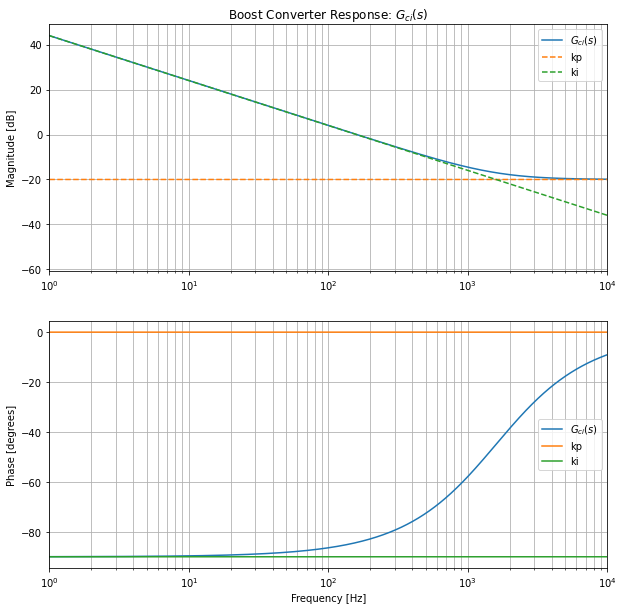

In [30]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
fsw = 10e3

ax[0].set_title('Boost Converter Response: $G_{ci}(s)$')
ax[0].semilogx(f,20*np.log10(abs(Gci)),label='$G_{ci}(s)$')
ax[0].semilogx(f,20*np.log10(kp)*np.ones(len(f)),label='kp',linestyle='--')
ax[0].semilogx(f,20*np.log10(abs(Gci_pole)),label='ki',linestyle='--')
ax[0].set_xlim([1,fsw])
ax[0].set_ylabel('Magnitude [dB]')
ax[0].grid(which='both', axis='both')
ax[0].legend()

ax[1].semilogx(f,np.angle(Gci,deg=True),label='$G_{ci}(s)$')
ax[1].semilogx(f,np.angle(kp*np.ones(len(f)),deg=True),label='kp')
ax[1].semilogx(f,np.angle(Gci_pole,deg=True),label='ki')
ax[1].set_xlim([1,fsw])
ax[1].set_ylabel('Phase [degrees]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(which='both', axis='both')
ax[1].legend()
plt.show();

### Gid

In [31]:
H0 = lambdify(s,H0,modules='numpy')
H0 = H0(1j*w)

In [32]:
H0_zero = lambdify(s,s+9.09,modules='numpy')
H0_zero = H0_zero(1j*w)

In [33]:
H0_pole0 = lambdify(s,1/(s+(152.27-737.31j)),modules='numpy')
H0_pole0 = H0_pole0(1j*w)

In [34]:
H0_pole1 = lambdify(s,1/(s+(152.27+737.31j)),modules='numpy')
H0_pole1 = H0_pole1(1j*w)

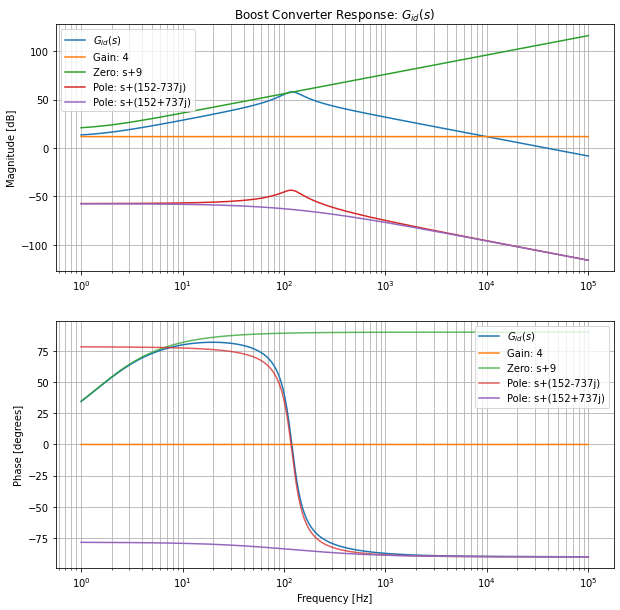

In [35]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
fsw = 25e3

ax[0].set_title('Boost Converter Response: $G_{id}(s)$')
ax[0].semilogx(f,20*np.log10(abs(H0)),label='$G_{id}(s)$')
ax[0].semilogx(f,20*np.log10(3.8492)*np.ones(len(f)),label='Gain: 4')
ax[0].semilogx(f,20*np.log10(abs(H0_zero)),label='Zero: s+9')
ax[0].semilogx(f,20*np.log10(abs(H0_pole0)),label='Pole: s+(152-737j)')
ax[0].semilogx(f,20*np.log10(abs(H0_pole1)),label='Pole: s+(152+737j)')
#ax[0].set_xlim([1,fsw/2])
ax[0].set_ylabel('Magnitude [dB]')
ax[0].grid(which='both', axis='both')
ax[0].legend()

ax[1].semilogx(f,np.angle(H0,deg=True),label='$G_{id}(s)$')
ax[1].semilogx(f,np.angle(3.8492*np.ones(len(f)),deg=True),label='Gain: 4')
ax[1].semilogx(f,np.angle(H0_zero,deg=True),label='Zero: s+9',alpha=0.75)
ax[1].semilogx(f,np.angle(H0_pole0,deg=True),label='Pole: s+(152-737j)',alpha=0.75)
ax[1].semilogx(f,np.angle(H0_pole1,deg=True),label='Pole: s+(152+737j)')
#ax[1].set_xlim([1,fsw/2])
ax[1].set_ylabel('Phase [degrees]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(which='both', axis='both')
ax[1].legend()
plt.show();

### Gvd

In [36]:
H = sp.Matrix(tf)

In [37]:
H2 = lambdify(s,H2,modules='numpy')
H2 = H2(1j*w)

In [38]:
H2_zero = lambdify(s,s-124101.23,modules='numpy')
H2_zero = H2_zero(1j*w)

In [39]:
H2_pole0 = lambdify(s,1/(s+(152.27-737.31j)),modules='numpy')
H2_pole0 = H2_pole0(1j*w)

In [40]:
H2_pole1 = lambdify(s,1/(s+(152.27+737.31j)),modules='numpy')
H2_pole1 = H2_pole1(1j*w)

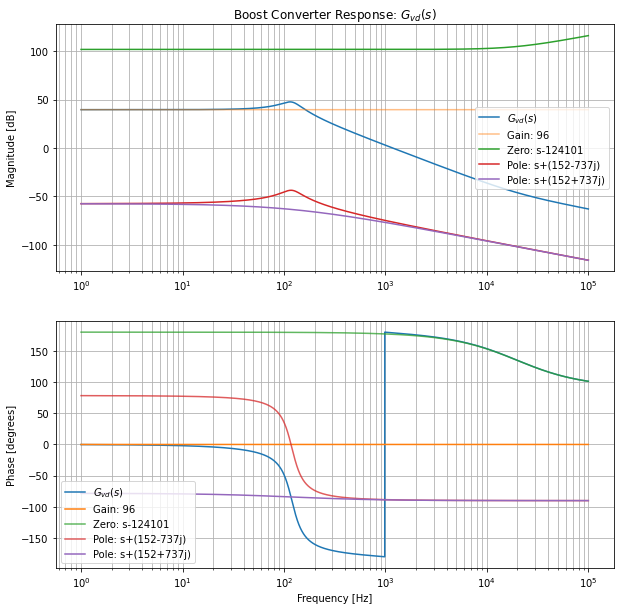

In [41]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
fsw = 25e3

ax[0].set_title('Boost Converter Response: $G_{vd}(s)$')
ax[0].semilogx(f,20*np.log10(abs(H2)),label='$G_{vd}(s)$')
ax[0].semilogx(f,20*np.log10(95.76738)*np.ones(len(f)),label='Gain: 96',alpha=0.5)
ax[0].semilogx(f,20*np.log10(abs(H2_zero)),label='Zero: s-124101')
ax[0].semilogx(f,20*np.log10(abs(H2_pole0)),label='Pole: s+(152-737j)')
ax[0].semilogx(f,20*np.log10(abs(H2_pole1)),label='Pole: s+(152+737j)')
#ax[0].set_xlim([1,fsw/2])
ax[0].set_ylabel('Magnitude [dB]')
ax[0].grid(which='both', axis='both')
ax[0].legend()

ax[1].semilogx(f,np.angle(H2,deg=True),label='$G_{vd}(s)$')
ax[1].semilogx(f,np.angle(95.76738*np.ones(len(f)),deg=True),label='Gain: 96')
ax[1].semilogx(f,np.angle(H2_zero,deg=True),label='Zero: s-124101',alpha=0.75)
ax[1].semilogx(f,np.angle(H2_pole0,deg=True),label='Pole: s+(152-737j)',alpha=0.75)
ax[1].semilogx(f,np.angle(H2_pole1,deg=True),label='Pole: s+(152+737j)')
#ax[1].set_xlim([1,fsw/2])
ax[1].set_ylabel('Phase [degrees]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(which='both', axis='both')
ax[1].legend()
plt.show();

### Gvd/Gid

In [42]:
s,n,R_L,R,L,C,D,Dp,V_g = sp.symbols("s,n,R_L,R,L,C,D,D',V_g")

In [43]:
H4 = (Dp**2*R-L*s-R_L)/(Dp*(R*C*s+2))

In [44]:
system = {
    'R_L':60e-3,
    'R'  :100,
    'L'  :0.2e-3,
    'C'  :2200e-6,
    "D'"  :0.4988,
    'V_g' :24
}
H4 = H4.subs(system)

In [45]:
H4 = lambdify(s,H4,modules='numpy')
H4 = H4(1j*w)

In [46]:
H4_zero = lambdify(s,s-124101.23,modules='numpy')
H4_zero = H4_zero(1j*w)

In [47]:
H4_pole0 = lambdify(s,1/(s+9.0909),modules='numpy')
H4_pole0 = H4_pole0(1j*w)

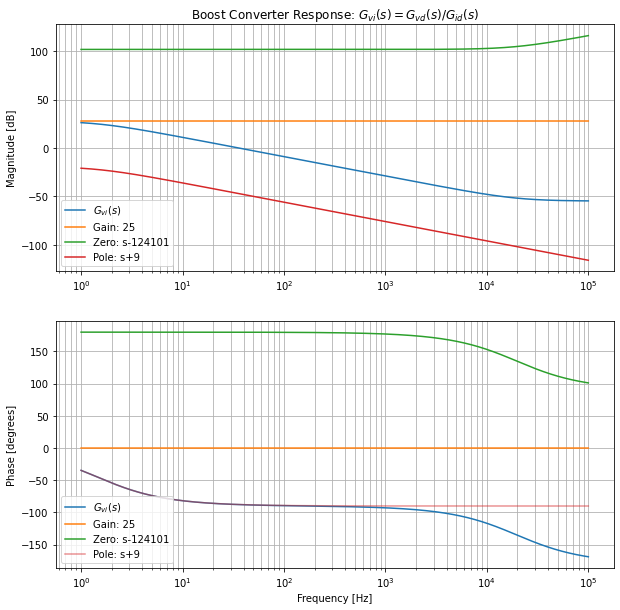

In [48]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
fsw = 25e3

ax[0].set_title('Boost Converter Response: $G_{vi}(s)= G_{vd}(s)/G_{id}(s)$')
ax[0].semilogx(f,20*np.log10(abs(H4)),label='$G_{vi}(s)$')
ax[0].semilogx(f,20*np.log10(24.87985)*np.ones(len(f)),label='Gain: 25')
ax[0].semilogx(f,20*np.log10(abs(H4_zero)),label='Zero: s-124101')
ax[0].semilogx(f,20*np.log10(abs(H4_pole0)),label='Pole: s+9')
#ax[0].set_xlim([1,fsw/2])
ax[0].set_ylabel('Magnitude [dB]')
ax[0].grid(which='both', axis='both')
ax[0].legend()

ax[1].semilogx(f,np.angle(H4,deg=True),label='$G_{vi}(s)$')
ax[1].semilogx(f,np.angle(24.87985*np.ones(len(f)),deg=True),label='Gain: 25')
ax[1].semilogx(f,np.angle(H4_zero,deg=True),label='Zero: s-124101')
ax[1].semilogx(f,np.angle(H4_pole0,deg=True),label='Pole: s+9',alpha=0.5)
#ax[1].set_xlim([1,fsw/2])
ax[1].set_ylabel('Phase [degrees]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(which='both', axis='both')
ax[1].legend()
plt.show();